# Importing packages and reading in the csv file

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras.layers import Dense, Input, Dropout, BatchNormalization, Flatten
from keras.metrics import AUC, Precision, Recall, F1Score
from keras.losses import BinaryCrossentropy, BinaryFocalCrossentropy
from keras.optimizers import Adam, RMSprop, Adadelta, Adagrad, AdamW, Adamax
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv("final_data.csv")
print(df.shape)
df.head()

(529, 66)


,PCOS (Y/N),Age (yrs),BMI,Pulse rate(bpm),Menstrual Cycle Length(days),Marriage Status (Yrs),Pregnant(Y/N),No. of abortions,I beta-HCG(mIU/mL),II beta-HCG(mIU/mL),...,RBS(mg/dl)_low,RBS(mg/dl)_normal,BP _Systolic (mmHg)_high,BP _Systolic (mmHg)_normal,BP _Diastolic (mmHg)_high,BP _Diastolic (mmHg)_normal,I beta-HCG cat_abnormal,I beta-HCG cat_normal,II beta-HCG cat_abnormal,II beta-HCG cat_normal
0,0,28,19.3,78,5,7.0,0,0,1.99,1.99,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,0,36,24.9,74,5,11.0,1,0,60.80,1.99,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
2,1,33,25.3,72,5,10.0,1,0,494.08,494.08,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,0,37,29.7,72,5,4.0,0,0,1.99,1.99,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,0,25,20.1,72,5,1.0,1,0,801.45,801.45,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


In [3]:
df.columns

Index(['PCOS (Y/N)', 'Age (yrs)', 'BMI', 'Pulse rate(bpm)',
       'Menstrual Cycle Length(days)', 'Marriage Status (Yrs)',
       'Pregnant(Y/N)', 'No. of abortions', 'I   beta-HCG(mIU/mL)',
       'II    beta-HCG(mIU/mL)', 'FSH/LH', 'Waist:Hip Ratio',
       'Weight gain(Y/N)', 'hair growth(Y/N)', 'Skin darkening (Y/N)',
       'Hair loss(Y/N)', 'Pimples(Y/N)', 'Fast food (Y/N)',
       'Reg.Exercise(Y/N)', 'Follicle No. (L)', 'Follicle No. (R)',
       'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)', 'Endometrium (mm)',
       'Blood Group_A+', 'Blood Group_A-', 'Blood Group_AB+',
       'Blood Group_AB-', 'Blood Group_B+', 'Blood Group_B-', 'Blood Group_O+',
       'Blood Group_O-', 'Menstrual Cycle(R/I)_irregular',
       'Menstrual Cycle(R/I)_regular', 'Symptoms score',
       'Unhealthy living score', 'RR (breaths/min)_high',
       'RR (breaths/min)_normal', 'Hb(g/dl)_low', 'Hb(g/dl)_normal',
       'TSH (mIU/L)_high', 'TSH (mIU/L)_low', 'TSH (mIU/L)_normal',
       'AMH(ng/mL)_

# Sets a random seed to ensure reproducible results

In [6]:
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
"""
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)"
"""

'\nfrom keras import backend as K\nsession_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)\nsess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)\ntf.compat.v1.keras.backend.set_session(sess)"\n'

# Finding the class weights to resolve the issue of class imbalance

In [5]:
target_counts = np.bincount(df["PCOS (Y/N)"])
weight_for_0 = 1.0/target_counts[0]
weight_for_1 = 1.0/target_counts[1]

# Feature Selection Using RFE 

In [7]:
target_column = "PCOS (Y/N)"
y = df[target_column]
X = df.drop(target_column, axis=1)

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
selector = RFECV(estimator=rf, cv=5, step=1, scoring='roc_auc')
selector = selector.fit(X, y)
selected_columns = X.columns[selector.support_]
print(selected_columns)
X = X[selected_columns]
X

Index(['Age (yrs)', 'BMI', 'Pulse rate(bpm)', 'Menstrual Cycle Length(days)',
       'Marriage Status (Yrs)', 'Pregnant(Y/N)', 'No. of abortions',
       'I   beta-HCG(mIU/mL)', 'II    beta-HCG(mIU/mL)', 'FSH/LH',
       'Waist:Hip Ratio', 'Weight gain(Y/N)', 'hair growth(Y/N)',
       'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)',
       'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'Follicle No. (L)',
       'Follicle No. (R)', 'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)',
       'Endometrium (mm)', 'Blood Group_B+', 'Blood Group_O+',
       'Menstrual Cycle(R/I)_irregular', 'Menstrual Cycle(R/I)_regular',
       'Symptoms score', 'Unhealthy living score', 'Hb(g/dl)_low',
       'Hb(g/dl)_normal', 'TSH (mIU/L)_high', 'TSH (mIU/L)_normal',
       'AMH(ng/mL)_high', 'AMH(ng/mL)_low', 'AMH(ng/mL)_normal',
       'PRL(ng/mL)_high', 'PRL(ng/mL)_normal', 'Vit D3 (ng/mL)_low',
       'Vit D3 (ng/mL)_normal', 'I beta-HCG cat_abnormal',
       'I beta-HCG cat_normal', 'II beta-HCG cat_

,Age (yrs),BMI,Pulse rate(bpm),Menstrual Cycle Length(days),Marriage Status (Yrs),Pregnant(Y/N),No. of abortions,I beta-HCG(mIU/mL),II beta-HCG(mIU/mL),FSH/LH,...,AMH(ng/mL)_low,AMH(ng/mL)_normal,PRL(ng/mL)_high,PRL(ng/mL)_normal,Vit D3 (ng/mL)_low,Vit D3 (ng/mL)_normal,I beta-HCG cat_abnormal,I beta-HCG cat_normal,II beta-HCG cat_abnormal,II beta-HCG cat_normal
0,28,19.3,78,5,7.0,0,0,1.99,1.99,2.16,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,36,24.9,74,5,11.0,1,0,60.80,1.99,6.17,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,33,25.3,72,5,10.0,1,0,494.08,494.08,6.30,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,37,29.7,72,5,4.0,0,0,1.99,1.99,3.42,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,25,20.1,72,5,1.0,1,0,801.45,801.45,4.42,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,35,18.5,72,5,8.0,0,1,1.99,1.99,5.56,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
525,30,25.3,72,5,4.0,1,1,80.13,1.99,1.79,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
526,36,23.4,74,6,8.0,0,0,1.99,1.99,4.30,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
527,27,22.2,74,2,2.0,0,0,292.92,1.99,1.02,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


# Splitting into train, validation and test datasets

In [8]:
# Choose either 60, 20, 20 or 80, 10, 10
# Depends on the complexity of the model, the dataset size and the nature of the data

test_size_1 = 0.4
test_size_2 = 0.5
random_state = 1

from sklearn.model_selection import train_test_split
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=test_size_1, stratify=y, random_state=random_state)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=test_size_2, stratify=y_valtest, random_state=random_state)

# Scaling numerical columns (Standardization)

In [10]:
X_train.columns

Index(['Age (yrs)', 'BMI', 'Pulse rate(bpm)', 'Menstrual Cycle Length(days)',
       'Marriage Status (Yrs)', 'Pregnant(Y/N)', 'No. of abortions',
       'I   beta-HCG(mIU/mL)', 'II    beta-HCG(mIU/mL)', 'FSH/LH',
       'Waist:Hip Ratio', 'Weight gain(Y/N)', 'hair growth(Y/N)',
       'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)',
       'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'Follicle No. (L)',
       'Follicle No. (R)', 'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)',
       'Endometrium (mm)', 'Blood Group_B+', 'Blood Group_O+',
       'Menstrual Cycle(R/I)_irregular', 'Menstrual Cycle(R/I)_regular',
       'Symptoms score', 'Unhealthy living score', 'Hb(g/dl)_low',
       'Hb(g/dl)_normal', 'TSH (mIU/L)_high', 'TSH (mIU/L)_normal',
       'AMH(ng/mL)_high', 'AMH(ng/mL)_low', 'AMH(ng/mL)_normal',
       'PRL(ng/mL)_high', 'PRL(ng/mL)_normal', 'Vit D3 (ng/mL)_low',
       'Vit D3 (ng/mL)_normal', 'I beta-HCG cat_abnormal',
       'I beta-HCG cat_normal', 'II beta-HCG cat_

In [11]:
cat_cols = ['Blood Group_A+', 'Blood Group_A-', 'Blood Group_AB+','Blood Group_AB-', 
'Blood Group_B+', 'Blood Group_B-', 'Blood Group_O+', 'Blood Group_O-', 
'Menstrual Cycle(R/I)_irregular', 'Menstrual Cycle(R/I)_regular', 'Weight gain(Y/N)', 
'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)',
'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'Pregnant(Y/N)']
numerical_cols =  [col for col in list(X_train.columns) if col not in cat_cols]
numerical_cols

['Age (yrs)',
 'BMI',
 'Pulse rate(bpm)',
 'Menstrual Cycle Length(days)',
 'Marriage Status (Yrs)',
 'No. of abortions',
 'I   beta-HCG(mIU/mL)',
 'II    beta-HCG(mIU/mL)',
 'FSH/LH',
 'Waist:Hip Ratio',
 'Follicle No. (L)',
 'Follicle No. (R)',
 'Avg. F size (L) (mm)',
 'Avg. F size (R) (mm)',
 'Endometrium (mm)',
 'Symptoms score',
 'Unhealthy living score',
 'Hb(g/dl)_low',
 'Hb(g/dl)_normal',
 'TSH (mIU/L)_high',
 'TSH (mIU/L)_normal',
 'AMH(ng/mL)_high',
 'AMH(ng/mL)_low',
 'AMH(ng/mL)_normal',
 'PRL(ng/mL)_high',
 'PRL(ng/mL)_normal',
 'Vit D3 (ng/mL)_low',
 'Vit D3 (ng/mL)_normal',
 'I beta-HCG cat_abnormal',
 'I beta-HCG cat_normal',
 'II beta-HCG cat_abnormal',
 'II beta-HCG cat_normal']

In [12]:
# data standardization with sklearn
from sklearn.preprocessing import StandardScaler

# copy of datasets
X_train_stand = X_train.copy()
X_val_stand = X_val.copy()
X_test_stand = X_test.copy()

# apply standardization on numerical features
for i in numerical_cols:
    
    # fit on training data column
    scale = StandardScaler().fit(X_train_stand[[i]])
    
    # transform the training data column
    X_train_stand[i] = scale.transform(X_train_stand[[i]])
    
    # transform the validation data column
    X_val_stand[i] = scale.transform(X_val_stand[[i]])

    # transform the testing data column
    X_test_stand[i] = scale.transform(X_test_stand[[i]])

# Building a neural network (Keras Functional API)

In [13]:
inputs = Input(shape=X_train_stand.shape[1:])
x = Dense(32, activation="relu")(inputs)
x = Dense(32, activation="relu")(x)
x = Dropout(rate=0.2, seed=1)(x)
x = Dense(32, activation="relu")(x)
x = BatchNormalization()(x)
outputs = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 44)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,713 (14.50 KB)

 Trainable params: 3,649 (14.25 KB)

 Non-trainable params: 64 (256.00 B)

In [16]:
keras.utils.plot_model(model, "my_first_model.png", show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [17]:
my_callbacks = [
    #keras.callbacks.EarlyStopping(patience=2, min_delta=0.0012),
    #keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    #keras.callbacks.TensorBoard(log_dir='./logs')
]

In [20]:
model.compile(loss= BinaryCrossentropy() , optimizer=Adam() , metrics=[AUC, Precision, Recall]) 
history = model.fit(x=X_train_stand, y=y_train, batch_size=64, epochs=50, validation_data=(X_val_stand, y_val), class_weight={0: weight_for_0, 1: weight_for_1}, callbacks=my_callbacks)
test_loss, test_auc, test_precision, test_recall = model.evaluate(X_test_stand, y_test, verbose=2)
print(test_loss, test_auc, test_precision, test_recall)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - auc_2: 0.9999 - loss: 1.2310e-04 - precision_2: 0.9878 - recall_2: 0.9817 - val_auc_2: 0.8893 - val_loss: 0.4610 - val_precision_2: 0.8235 - val_recall_2: 0.8235
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc_2: 0.9998 - loss: 1.3249e-04 - precision_2: 0.9878 - recall_2: 0.9817 - val_auc_2: 0.8862 - val_loss: 0.4759 - val_precision_2: 0.8182 - val_recall_2: 0.7941
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc_2: 1.0000 - loss: 8.5331e-05 - precision_2: 1.0000 - recall_2: 1.0000 - val_auc_2: 0.8840 - val_loss: 0.4893 - val_precision_2: 0.8182 - val_recall_2: 0.7941
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc_2: 0.9997 - loss: 9.4577e-05 - precision_2: 1.0000 - recall_2: 0.9967 - val_auc_2: 0.8826 - val_loss: 0.4996 - val_precision_2: 0.8182 - val_recall_2: 0.7941
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - auc_2: 0.9992 - loss: 1.2797e-04 - precision_2: 0.9847 - recall_2: 0.9918 - val_auc_2: 0.8868 - 

# Using Keras_tuner

In [21]:
import keras_tuner
class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        # Tune the number of layers.
        inputs = Input(shape=X_train.shape[1:])
        x = Dense(32, activation="relu")(inputs)
        for i in range(hp.Int("num_layers", 1, 4)):
            x = Dense(
                    # Tune number of units separately.
                    units=hp.Int(f"units_{i}", min_value=32, max_value=320, step=32),
                    activation=hp.Choice(f"activation_{i}", ["relu", "tanh"])
                )(x)
        if hp.Boolean("dropout"):
            x = (Dropout(rate=hp.Float("dropout_rate", min_value=0.1, max_value=0.3, step=0.1)))(x)
        if hp.Boolean("batch_norm"): 
            x = BatchNormalization()(x)
        outputs = Dense(1, activation="sigmoid")(x)
        model = Model(inputs=inputs, outputs=outputs) 
        learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
        model.compile(loss=BinaryCrossentropy(), optimizer=Adam(learning_rate=learning_rate) , metrics=[AUC]) 
        return model

    # It is generally not needed to tune the number of epochs because a built-in callback is passed to model.fit()
    # to save the model at its best epoch evaluated by the validation_data.
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Int("batch_size", min_value=32, max_value=128, step=32),
            **kwargs
        )

In [22]:
# Quick check to see if the code is working correctly
hp = keras_tuner.HyperParameters()
hypermodel = MyHyperModel()
model = hypermodel.build(hp)
hypermodel.fit(hp, model, x=X_train_stand, y=y_train, validation_data=(X_val_stand, y_val), class_weight={0: weight_for_0, 1: weight_for_1})

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc_3: 0.4504 - loss: 0.0028 - val_auc_3: 0.4026 - val_loss: 0.7177


During the search, the model-building function is called with different hyperparameter values in different trial. In each trial, the tuner would generate a new set of hyperparameter values to build the model. The model is then fit and evaluated. The metrics are recorded. The tuner progressively explores the space and finally finds a good set of hyperparameter values.

In [23]:
# Select a tuner class: RandomSearch, BayesianOptimization and Hyperband (Each corresponds to one tuning algorithm.)
tuner = keras_tuner.RandomSearch(
    hypermodel=MyHyperModel(),
    objective=keras_tuner.Objective("val_auc", direction="max"),
    max_trials=5,
    overwrite=True,
    directory="neural_network_results",
    project_name="tune_hypermodel"
)
tuner.search_space_summary()


Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 320, 'step': 32, 'sampling': 'linear'}
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
batch_norm (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [24]:
tuner.search(x=X_train_stand, y=y_train, validation_data=(X_val_stand, y_val), class_weight={0: weight_for_0, 1: weight_for_1}, callbacks=my_callbacks)
tuner.results_summary()

Trial 5 Complete [00h 00m 02s]
val_auc: 0.9070670008659363

Best val_auc So Far: 0.9070670008659363
Total elapsed time: 00h 00m 12s
Results summary
Results in neural_network_results\tune_hypermodel
Showing 10 best trials
Objective(name="val_auc", direction="max")

Trial 4 summary
Hyperparameters:
num_layers: 3
units_0: 192
activation_0: relu
dropout: False
batch_norm: True
lr: 0.005283071526371937
units_1: 256
activation_1: relu
units_2: 32
activation_2: relu
batch_size: 32
units_3: 64
activation_3: relu
dropout_rate: 0.2
Score: 0.9070670008659363

Trial 3 summary
Hyperparameters:
num_layers: 4
units_0: 96
activation_0: relu
dropout: True
batch_norm: False
lr: 0.004116823186183904
units_1: 288
activation_1: tanh
units_2: 192
activation_2: relu
batch_size: 32
units_3: 256
activation_3: tanh
dropout_rate: 0.1
Score: 0.8988970518112183

Trial 2 summary
Hyperparameters:
num_layers: 1
units_0: 64
activation_0: tanh
dropout: True
batch_norm: False
lr: 0.008516344844733455
units_1: 192
activa

In [25]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=1)
best_model = models[0]
best_model.summary()

c:\Users\Stacy\anaconda\envs\dsa4262_pcos\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 44)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 192)            │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,569 (256.13 KB)

 Trainable params: 65,505 (255.88 KB)

 Non-trainable params: 64 (256.00 B)

# Retraining and evaluation

In [26]:
best_hps = tuner.get_best_hyperparameters(1)
# Build the model with the best hp.
hypermodel = MyHyperModel()
model = hypermodel.build(best_hps[0])
# Fit with the entire dataset.
x_all = np.concatenate((X_train_stand, X_val_stand))
y_all = np.concatenate((y_train, y_val))
history = model.fit(x=x_all, y=y_all, epochs=3, class_weight={0: weight_for_0, 1: weight_for_1})
test_loss, test_auc = model.evaluate(X_test_stand, y_test, verbose=2)
print(test_loss, test_auc)

Epoch 1/3
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - auc: 0.7887 - loss: 0.0022
Epoch 2/3
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.9497 - loss: 0.0011 
Epoch 3/3
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9724 - loss: 8.3452e-04 
4/4 - 0s - 53ms/step - auc: 0.9441 - loss: 0.7823
0.7823405861854553 0.9440644383430481


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


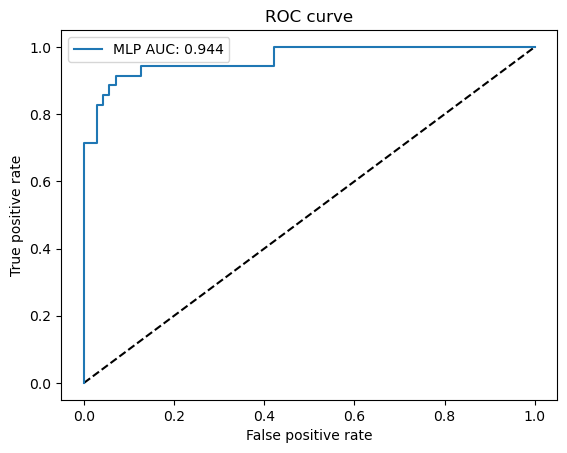

In [27]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
y_pred_proba = model.predict(X_test_stand).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='MLP AUC: {:.3f}'.format(test_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Finding the best threshold

In [28]:
# This method minimizes the distance to the top-left corner of the ROC space.
distances = np.sqrt((1 - tpr) ** 2 + fpr ** 2)
best_thresh = thresholds[np.argmin(distances)]
print(f"Best threshold: {best_thresh}")

Best threshold: 0.9685145616531372


Precision: 0.86
Recall: 0.91
Specificity: 0.93
Sensitivity: 0.91


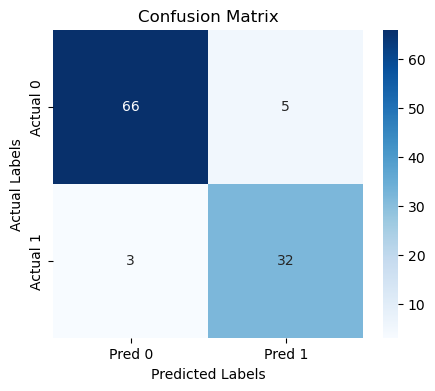

              precision    recall  f1-score   support

           0       0.96      0.93      0.94        71
           1       0.86      0.91      0.89        35

    accuracy                           0.92       106
   macro avg       0.91      0.92      0.92       106
weighted avg       0.93      0.92      0.93       106



In [29]:
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix
import seaborn as sns

y_pred = [1 if prob>=best_thresh else 0 for prob in y_pred_proba]

# Compute Precision and Recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

# Compute Sensitivity and Specificity
specificity = recall_score(y_test, y_pred, pos_label=0)

print(f'Specificity: {specificity:.2f}')
print(f'Sensitivity: {recall:.2f}')

# Visualise the confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ["True Negatives (TN)", "False Positives (FP)", "False Negatives (FN)", "True Positives (TP)"]

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Pred 0", "Pred 1"], yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()


# Visualise the classification report
report = classification_report(y_test, y_pred)
print(report)